In [2]:
import sys; sys.path.append('..'); from wwa import *
cproj = cartopy.crs.PlateCarree()

xn, xx, yn, yx = [-85,-75,6,10]
Xn, Xx, Yn, Yx = [-85,-75,5,15]
xn, xx, yn, yx = [-80.5,-79.25,8.7,9.7] 

units = {"pr" : "mm/day", "tasmin" : "degC", "tasmax" : "degC"}

---
---
# Observational datasets

---
## CHIRPS

In [ ]:
chirps = xr.open_mfdataset("../../00_WWA_project_folder/live/data/chirps_05/*.nc").sel(longitude = slice(xn,xx), latitude = slice(yn, yx)).rename("pr", latitude = "lat", longitude = "lon")
chirps.to_netcdf("data/chirps05_panama.nc")

In [69]:
chirps = xr.open_dataset("data/chirps05_panama.nc")

# daily & monthly time series
chirps_ts = chirps.mean(["lat", "lon"])
chirps_ts.to_netcdf("data/chirps_panama_ts.nc")
chirps_ts.resample(time = "MS").sum().to_netcdf("data/pr_monthly_chirps.nc")

# monthly maps
chirps = chirps.resample(time = "MS").sum()
chirps = chirps.where(chirps.sum("time") > 0)
chirps.to_netcdf("data/chirps05_panama_monthly.nc")

In [148]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
chirps.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-bci.nc")
chirps.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-gamboa.nc")

### Fitted model per grid cell

#### Flatten data for model fitting

In [60]:
xn, xx, yn, yx = [-80.5,-79.25,8.7,9.7] # revised after comparison with station data

# accumulated rainy season precip
chirps = xr.open_dataset("data/chirps05_panama.nc").pr
chirps = chirps.sel(time = [m > 4 for m in chirps.time.dt.month.values]).resample(time = "AS-JAN").sum()

chirps_rs = chirps.where(chirps > 0).assign_coords(time = chirps.time.dt.year).rename(time = "year").sel(lon = slice(xn,xx), lat = slice(yn, yx))
chirps_rs.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas().to_csv("data/chirps_pr-MJJASOND_flattened.csv")

#### Reshape fitted results

In [61]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [62]:
chirps_tmplt = xr.ones_like(chirps_rs.isel(year = -1, drop = True)).where(chirps_rs.sum("year") > 0)
df = pd.read_csv("res/res_rs_chirps-gridded.csv", index_col = 0)
mdl_res = xr.merge([vec2map(df.loc[r], chirps_tmplt).rename(r) for r in df.index])
mdl_res.to_netcdf("res/res_rs_chirps-gridded.nc")

## MSWEP/MSWX

### Compile

In [ ]:
# cut out yearly slices
for y in range(2024, 1978, -1)[:2]:
    
    new_fnm = "mswep/mswep_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../../00_WWA_project_folder/live/data/mswep_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(precipitation = "pr").to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswep_panama_*.nc").to_netcdf("data/mswep_panama.nc")

In [ ]:
varnm = "tmin"

# cut out yearly slices
for y in range(2024, 1978, -1):
    
    new_fnm = "mswep/mswx_"+varnm+"_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../00_WWA_project_folder/live/data/mswx/"+varnm+"_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(air_temperature = varnm).to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswx_"+varnm+"_panama_*.nc").to_netcdf("data/mswx_"+varnm+"_panama.nc")

### Extract time series

In [74]:
mswep = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx))
mswep_rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswep.lon, mswep.lat).sum("region")

In [76]:
# land surface only
mswep = mswep.where(mswep_rm == 1)

# daily & monthly time series
mswep_ts = mswep.mean(["lat", "lon"])
mswep_ts.to_netcdf("data/mswep_panama_ts.nc")
mswep_ts.resample(time = "MS").sum().to_netcdf("data/pr_monthly_mswep.nc")

# monthly maps
mswep = mswep.resample(time = "MS").sum()
mswep = mswep.where(mswep.sum("time") > 0)
mswep.to_netcdf("data/mswep_panama_monthly.nc")

In [50]:
vnm = "tmin"

mswx = xr.open_dataset("data/mswx_"+vnm+"_panama.nc")[vnm].sel(lon = slice(xn,xx), lat = slice(yn, yx))

# land surface only
mswx = mswx.where(mswep_rm == 1)

# daily & monthly time series
mswx_ts = mswx.mean(["lat", "lon"])
mswx_ts.to_netcdf("data/mswx-"+vnm+"_panama_ts.nc")
mswx_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswx-"+vnm+"_ts_monthly.csv")

# monthly maps
mswx = mswx.resample(time = "MS").sum()
mswx = mswx.where(mswx.sum("time") > 0)
mswx.to_netcdf("data/mswx-"+vnm+"_panama_monthly.nc")

In [149]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
mswep.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-bci.nc")
mswep.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-gamboa.nc")

### Compute PET

In [ ]:
tmin = xr.open_dataset("data/mswx_tmin_panama.nc").tmin
tmax = xr.open_dataset("data/mswx_tmax_panama.nc").tmax

In [ ]:
methods = ["BR65", "HG85", "MB05"]

# compute PET, convert to mm/day, and save for later reference
for mthd in methods:
    pet = potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = mthd)
    pet = convert_units_to(pet, "mm/day", context = "hydro").rename("pet")
    pet = pet.resample(time = "MS").sum()
    pet.to_netcdf("data/pet-"+mthd.lower()+"_mswx_panama_monthly.nc")

In [ ]:
pet = xr.open_dataset("data/pet-hg85_mswx_panama_monthly.nc").pet

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(pet.lon, pet.lat).squeeze(drop = True)

[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).where(rm == 1).mean(["lat", "lon"]).to_netcdf("data/pet_monthly_mswx_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

In [110]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pet_monthly_mswx-bci_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

[None, None, None]

---
## ERA5land

In [25]:
era5l = convert_units_to(xr.open_dataset("data/era5land_pev_monthly.nc").pev, "mm")
era5l = era5l * era5l.time.dt.days_in_month / 4

In [26]:
era5l.sel(time = slice("2022-01", "2022-04")).sum("time").plot()

In [28]:
era5l_flattened = pd.read_csv("data/era5land_pet-ds_flattened.csv")
era5l_flattened

,lat,8.700000000000022,8.700000000000022.1,8.700000000000022.2,8.700000000000022.3,8.700000000000022.4,8.700000000000022.5,8.800000000000022,8.800000000000022.1,8.800000000000022.2,...,9.40000000000002.2,9.40000000000002.3,9.40000000000002.4,9.40000000000002.5,9.50000000000002,9.50000000000002.1,9.50000000000002.2,9.50000000000002.3,9.60000000000002,9.60000000000002.1
0,lon,-80.400000,-80.300000,-80.200000,-80.100000,-80.000000,-79.900000,-80.400000,-80.300000,-80.200000,...,-79.600000,-79.500000,-79.400000,-79.300000,-79.600000,-79.500000,-79.400000,-79.300000,-79.600000,-79.500000
1,year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970,10.245257,12.454943,13.089561,14.262505,11.721137,9.585724,5.706980,6.065785,9.844725,...,7.021457,12.740923,13.317723,12.700588,14.447596,14.721677,12.979631,10.256361,14.721481,10.963211
3,1971,9.983854,12.058215,12.614248,13.520288,11.013844,8.966932,5.576212,5.916538,9.592416,...,7.051209,12.851031,13.544072,12.884438,14.701143,14.981315,13.156579,10.386367,15.066080,11.118767
4,1972,11.363832,13.861313,14.587269,15.751419,12.865384,10.392340,6.125422,6.540477,10.875587,...,7.376125,13.632772,14.397694,13.775737,14.760634,15.177364,13.384581,10.626428,14.682480,11.037878
5,1973,13.124593,16.315527,17.368444,19.013887,15.493007,12.330614,6.748764,7.286841,12.701368,...,8.578941,16.501997,17.140606,16.107582,18.234238,18.710249,16.241726,12.604094,18.077501,13.141958
6,1974,11.239685,13.490545,13.958141,15.407746,13.072835,10.772392,5.927198,6.259588,10.036656,...,7.679917,14.102832,14.479246,13.570374,15.911528,16.085554,13.881680,10.849239,16.129015,11.762887
7,1975,13.199736,16.266998,17.145948,18.811090,15.543543,12.446725,6.701166,7.220233,12.406206,...,8.612031,16.425179,16.716140,15.440971,18.517899,18.784620,16.007198,12.260962,18.429428,13.157079
8,1976,12.927868,16.127228,17.169674,18.929249,15.659542,12.478839,6.609087,7.186864,12.585386,...,8.749219,16.924183,17.301716,16.065512,18.889996,19.309984,16.584290,12.778334,18.781906,13.496502
9,1977,13.900111,17.224327,18.203245,20.134481,16.728367,13.372304,6.942255,7.496161,13.010457,...,8.662349,16.486090,16.863916,15.667237,18.291908,18.587963,15.945909,12.296056,18.061441,13.058925


---
# Station data

## Panama Canal Authority sites

In [18]:
## PRIOR TO 2023 (monthly resolution) ##

# load data, create headers from first three rows
acp_pr = pd.read_excel("data/Monthly Rain_ACP_Vertical.xlsx", sheet_name = "Rain.All", header = None)
acp_pr.columns = [" ".join([re.sub("nan", "", str(n)) for n in list(r)]).strip() for k, r in acp_pr.iloc[:3].items()]

# clean empty rows
acp_pr = acp_pr.iloc[3:]
acp_pr = acp_pr.loc[~acp_pr.Year.isna()]

# index by date & select columns of interest
acp_pr.index = [datetime.strptime(str(int(r["Year"])) + "-" +str(int(r["Month"])), "%Y-%m") for k,r in acp_pr.iterrows()]
acp_pr = acp_pr[[c for c in acp_pr.columns if not c in ["Year", "Month", "Yr.Mon", "Average", "1-yr", "3-yr", "5-year Running Average"]]]

# modify column names to match station data
acp_pr = acp_pr.rename(columns = {"CAÑO" : "CANO",
                                  "HODGESHILL GOLD HILL" : "GOLD HILL",
                                  "CRISTOBAL COCOSOLO LIMONBAY" : "LIMONBAY",
                                  "MONTELIRIO" : "MONTE LIRIO",
                                  "SAN PEDRO" : "SANPEDRO",
                                  "VALLECENTRALGATUN" : "VALLEGATUN",
                                  "CERROCOCOLI" : "COCOLI",
                                  "PEDROMIGEL" : "PEDROMIGUEL"})

acp_pr.to_csv("data/pr_stations_acp_monthly.csv")

In [ ]:
acp_stations = pd.read_excel("data/Monthly_Rain_ACP_Vertical.xlsx", sheet_name = "Locations", skiprows = 1)
acp_stations.index = [str(s).strip() for s in acp_stations["STRI Name"]]

# label stations as active/inactive & clean rows
acp_stations["STATUS"] = "Active"
acp_stations.iloc[list(acp_stations["ACP Name"].values).index("Deactivated Stations"):,-1] = "Deactivated"
acp_stations = acp_stations.loc[(~acp_stations["ACP Name"].isna()) & (acp_stations["ACP Name"] != "Deactivated Stations")]

# remove duplicate stations
acp_stations = acp_stations.loc[~((acp_stations.index == "PEDROMIGUEL") & (acp_stations.STATUS == "Deactivated"))]
acp_stations = acp_stations.loc[~((acp_stations.index == "RIOPIEDRAS") & (acp_stations.STATUS == "Deactivated"))]

# relabel lat & lon
acp_stations = acp_stations.rename(columns = {"LAT (N).1" : "lat", "LONG (W).1" : "lon"})

acp_stations.to_csv("data/acp_stations.csv")

## STRI sites

### Precipitation

In [ ]:
bocas = pd.read_excel("data/Monthly summaries_Bocas.xlsx", sheet_name = "Daily_Previous", index_col = "date", parse_dates = ["date"])
bocas = bocas.rename(columns = {"Rain" : "bocas"})[["bocas"]]

celestino = pd.read_excel("data/Monthly summaries_celestino.xlsx", sheet_name = "Daily_Prev", parse_dates = [0], skiprows = 3, header = None)
celestino = celestino.rename(columns = {0: "date", 1: "celestino"})[["date", "celestino"]].set_index("date")

culebra = pd.read_excel("data/Monthly summaries_culebra.xlsx", sheet_name = "Daily_Prev", skiprows = 4, parse_dates = [0], index_col = 0)
culebra = culebra.rename(columns = {"ra_sum": "culebra"})[["culebra"]]

galeta = pd.read_excel("data/Monthly summaries_galeta.xlsx", sheet_name = "Daily_Previous", skiprows = 3, header = None, parse_dates = [0])
galeta = galeta.rename(columns = {0: "date", 1: "galeta"})[["date", "galeta"]].set_index("date")

pnm = pd.read_excel("data/Monthly summaries_PNM.xlsx", sheet_name = "Daily_Prevous", parse_dates = [0], skiprows = 3, header = None)
pnm = pnm.rename(columns = {0: "date", 1: "pnm"})[["date", "pnm"]].set_index("date")

psl = pd.read_excel("data/Monthly summaries_PSL.xlsx", sheet_name = "Daily_previous", parse_dates = [0], skiprows = 2, header = None)
psl = psl.rename(columns = {0: "date", 1: "psl"})[["date", "psl"]].set_index("date")

In [371]:
# compile & save
stri_pr = merge_byindex([bocas, celestino, culebra, galeta, pnm, psl])
stri_pr = stri_pr.dropna(axis = 0, how = "all")
stri_pr.to_csv("data/pr_stations_stri_daily.csv")

In [ ]:
# stri metadata
stn_stri = pd.DataFrame.from_dict({"bci" : {"lon" : -82.256565, "lat" : 9.351553},
                                   "bocas" : {"lon" : -82.256565, "lat" : 9.351553},
                                     "celestino" : {"lon" : 79.72656, "lat" : 9.21142},
                                     "culebra" : {"lon" : -79.528919, "lat" : 8.910718},
                                     "galeta" : {"lon" : -79.860837, "lat" : 9.402742},
                                     "pnm" : {"lon" : -79.543000, "lat" : 8.994410},
                                     "psl" : {"lon" : -79.974518, "lat" : 9.281031},}).transpose()
stn_stri.to_csv("data/stations_stri.csv")

## Station composites

In [78]:
acp = pd.read_csv("data/pr_stations_acp_monthly.csv", index_col = 0, parse_dates = [0])

acp_nmonths = acp.resample("AS-JAN").count().where(acp.resample("AS-JAN").count() > 0)

acp_sat = acp.loc[slice("1979",None)].loc[:,acp_nmonths.loc[slice("1979",None)].count(axis = 0) > 40]
acp_mid = acp.loc[slice("1970",None)].loc[:,acp_nmonths.loc[slice("1970",None)].count(axis = 0) > 50]
acp_long = acp.loc[slice("1925",None)].loc[:,acp_nmonths.loc[slice("1925",None)].count(axis = 0) > 95]

In [81]:
# # save composite means as monthly time series
# acp_sat.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-sat.nc")
# acp_mid.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-mid.nc")
# acp_long.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-long.nc")

In [82]:
(acp.loc[slice("1882",None), "GAMBOA"].to_xarray().rename("pr", index = "time")).to_netcdf("data/pr_monthly_acp-GAMBOA.nc")
(acp.loc[slice("1926",None), "BCI"].to_xarray().rename("pr", index = "time")).to_netcdf("data/pr_monthly_acp-BCI.nc")

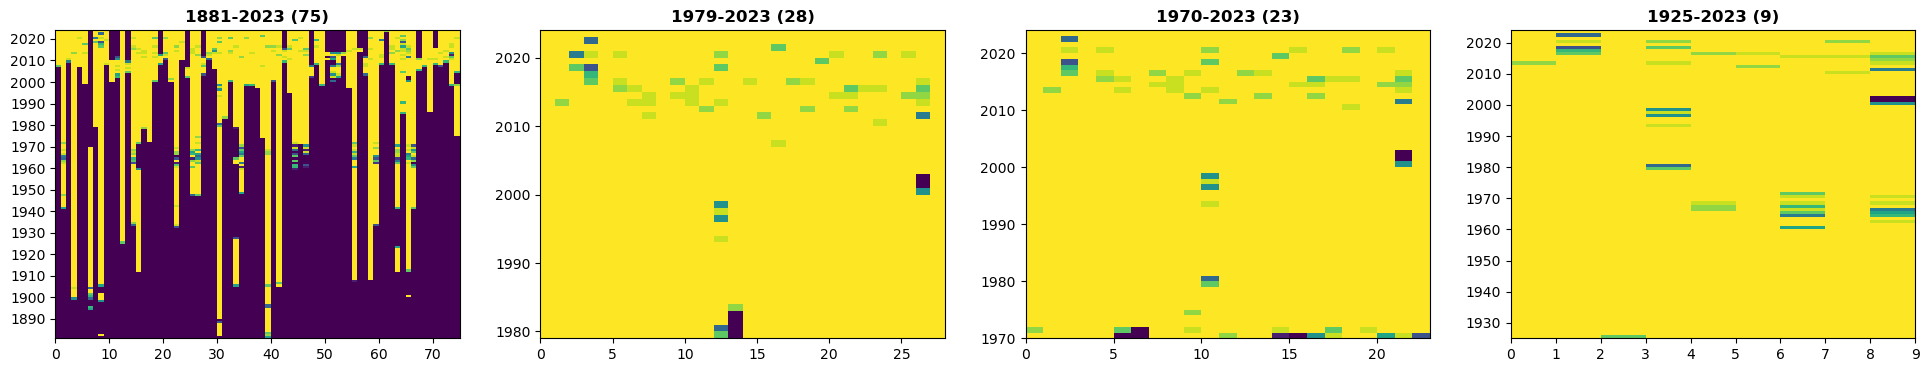

In [83]:
# how many stations are we left with when only complete stations are considered?
fig, axs = plt.subplots(ncols = 4, figsize = (24,4), dpi = 100)

for i in range(4):
    ax = axs[i]
    df = ([acp, acp_sat, acp_mid, acp_long][i]).resample("AS-JAN").count()

    ax.pcolormesh(df)
    ax.set_title(str(df.index.year.min())+"-"+str(df.index.year.max()) + " ("+str(len(df.columns))+")", fontweight = "bold")
    ax.set_yticks([df.index.year.tolist().index(y) for y in range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10)])
    ax.set_yticklabels(range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10))

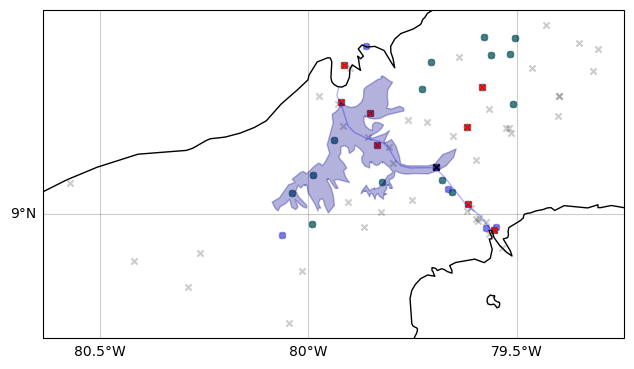

In [53]:
# which stations are we left with?
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)

fig, ax = plt.subplots(ncols = 1, figsize = (7.5,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

stn_data[["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "k", alpha = 0.2, marker = "x")

stn_data.loc[acp_sat.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "blue", alpha = 0.4)
stn_data.loc[acp_mid.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "green", alpha = 0.4)
stn_data.loc[acp_long.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "red", marker = "x", facecolor = "None")
stn_data.loc[["GAMBOA"], ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "k", marker = "x", facecolor = "None")

ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

<AxesSubplot: >

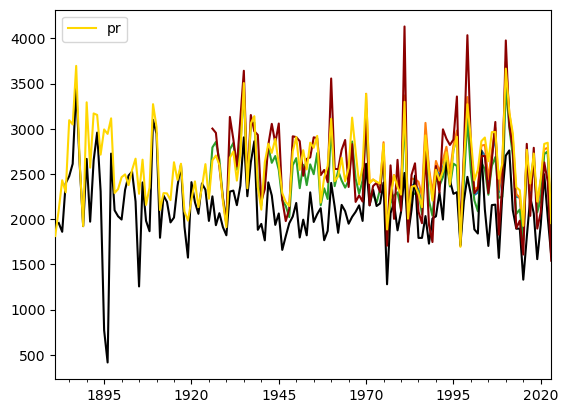

In [65]:
[ds.mean(axis = 1).resample("AS-JAN").sum().plot() for ds in [acp_sat, acp_mid, acp_long]]
acp.GAMBOA.loc[slice("1882",None)].resample("AS-JAN").sum().plot(color = "k")
acp.BCI.loc[slice("1926",None)].resample("AS-JAN").sum().plot(color = "darkred")
acp_sp.resample("AS-JAN").sum().plot(ax = plt.gca(), color = "gold", zorder = 99)

### Station composite provided by Steve Paton

In [47]:
# load composite created by Steve Paton
acp_sp = pd.read_excel("data/ACP monthly rainfall.xlsx", skiprows = 1, index_col = [0], nrows = 143, usecols = range(13))
acp_sp = pd.concat([pd.DataFrame(data = {"pr" : acp_sp.loc[y].values}, index = pd.date_range(datetime(y,1,1),datetime(y,12,1), freq = "MS")) for y in acp_sp.index])
acp_sp = acp_sp.dropna(axis = 0, how = "any")

acp_sp.to_xarray().rename(index = "time").to_netcdf("data/pr_monthly_acp-sp.nc")

#### Compare seasonal cycles & annual time series for different subsets
- similar seasonal cycle for all subsets except for Gamboa station
- Gamboa also quite different in terms of annual precip - 

Text(0.5, 1.0, 'Accumulated annual precipitation')

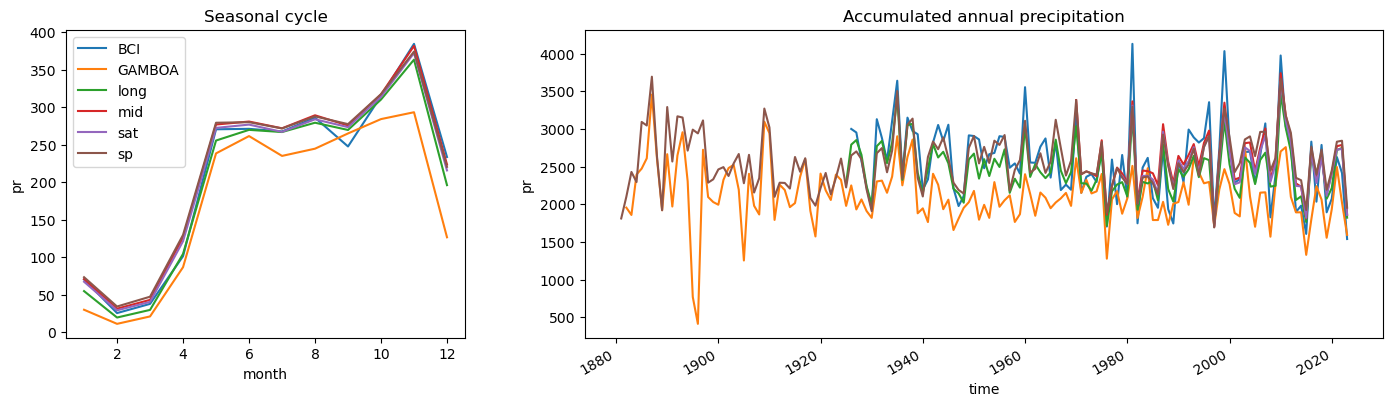

In [94]:
fig, axs = plt.subplots(ncols = 2, figsize = (17,4), dpi = 100, gridspec_kw = {"width_ratios" : [1,2]})
[xr.open_dataset(fnm).pr.sel(time = slice("1980", None)).groupby("time.month").mean().plot(ax = axs[0], label = fnm[20:-3]) for fnm in sorted(glob.glob("data/pr_monthly_acp-*.nc"))]
axs[0].legend()
axs[0].set_title("Seasonal cycle")

[xr.open_dataset(fnm).pr.resample(time = "AS-JAN").sum().plot(ax = axs[1], label = fnm[20:-3]) for fnm in sorted(glob.glob("data/pr_monthly_acp-*.nc"))]
axs[1].set_title("Accumulated annual precipitation")

## Barro Colorado Island

In [62]:
# monthly precipitation
bci_pr = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Rain_monthly", skiprows=1)
bci_pr.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Month"], "%Y-%b") for k,r in bci_pr.iterrows()]
bci_pr = bci_pr[["(mm)"]].rename(columns = {"(mm)" : "pr"})

# monthly evaporation
bci_evap = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Evapor", skiprows=2)
bci_evap.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Unnamed: 2"], "%Y-%b") for k,r in bci_evap.iterrows()]
bci_evap = bci_evap[["(mm)", "(mm).1"]].rename(columns = {"(mm)" : "evap_claro", "(mm).1" : "evap_42m"})

# monthly temperatures - manual records (monthly mean of tmax & tmin - maxima & minima also available if needed)
bci_temps_manual = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Temps_manual", skiprows=2)
bci_temps_manual.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Month"], "%Y-%b") for k,r in bci_temps_manual.iterrows()]
bci_temps_manual = bci_temps_manual[["Max..5", "Min..5"]].rename(columns = {"Max..5" : "tmax_manual", "Min..5" : "tmin_manual"})

# monthly temperatures - automatic records (monthly mean of tmean, tmax & tmin - maxima & minima also available if needed)
bci_temps_elec = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Temps_elect", skiprows=2)
bci_temps_elec.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Unnamed: 2"], "%Y-%b") for k,r in bci_temps_elec.iterrows()]
bci_temps_elec = bci_temps_elec.rename(columns = {"Avg" : "tmean_elec", "Avg.1" : "tmin_elec", "Avg.2" : "tmax_elec"})[["tmean_elec", "tmin_elec", "tmax_elec"]]

bci = merge_byindex([bci_pr, bci_evap, bci_temps_manual, bci_temps_elec])
bci.to_csv("data/bci_monthly.csv")

In [ ]:
px = {"bci" : {"lon" : -79.838234, "lat" : 9.163114}}
px = pd.DataFrame(px).transpose()

In [106]:
bci_evap.evap_claro.to_xarray().rename("pet", index = "time").to_netcdf("data/pet_monthly_acp-BCI_claro.nc")
bci_evap.evap_42m.to_xarray().rename("pet", index = "time").to_netcdf("data/pet_monthly_acp-BCI_42m.nc")

---
# Climate models

## HighResMIP

### Extract subset of data

In [2]:
# list & filter models
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/HighResMIP/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/highresmip/tmp/"

mdl_list = {varnm : list() for varnm in ["pr", "tasmin", "tasmax"]}

In [6]:
for fp in glob.glob(synda_path+"*/r1i1*"):
    print("_".join(fp.split("/")[-2:]))
    
    for varnm in list(mdl_list.keys()):
        
        fl = sorted(glob.glob(fp+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        if len(fl) == 0: 
            print("No data")
            continue
            
        # filter to remove any runs that don't cover the required period
        if min([fnm[-20:-16] for fnm in fl]) > "1980" or max([fnm[-11:-7] for fnm in fl]) < "2023": 
            print(str(min([fnm[-20:-16] for fnm in fl]))+"-"+str(max([fnm[-11:-7] for fnm in fl]))+" only")
            continue
            
        print("KEEP")
        mdl_list[varnm].append(fp)
      
    print("")
clear_output(wait = False)
print("Done.")

Done.


In [7]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        print(fp.split("/")[-2] + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        fl = sorted(glob.glob(fp+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
        
            new_fnm = out_path + re.sub("-present", "", re.sub("-future", "", fnm.split("/")[-1]))
            if os.path.exists(new_fnm): continue
                
            # if not already done, load the data & cut out the required region
            da = wrap_lon(convert_units_to(xr.open_dataset(fnm)[varnm].reset_coords(drop = True), units[varnm]))
            
            # fix dimension names if necessary
            if "longitude" in da.coords: da = da.rename(longitude = "lon", latitude = "lat")
            
            # save daily data over slightly larger region
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna("lon", "all").dropna("lat", "all")
            sp = da.sel({"lon" : box.lon, "lat" : box.lat})
            sp.to_netcdf(new_fnm)
            
            print(".", end = "")

        print("")
    clear_output(wait = False)
print("Done.")

Done.


### Compile into single dataset

---
## CMIP6

Downloaded via synda:
`synda search project=CMIP6 variant_label=r1i1p1f1 experiment_id='ssp585,historical' frequency=day variable='pr,tasmin,tasmax'  local_path_drs_template=CMIP6/%(source_id)s/%(variable)s`

---
## CORDEX
_Downloaded via synda_

In [ ]:
# remove files that only provide one annoying extra month that makes open_mfdataset fail
! rm wwa/24-03_Panama-drought/cordex/tmp/*20051101*.nc

In [107]:
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/cordex/tmp/"

In [108]:
# filter out any models that don't have both historical & rcp85
model_list = [m for m in sorted(glob.glob(synda_path+"*/*/*/*")) if "CAM-" in m or "SAM- in m"]
mdl_list = {k : list() for k in ["pr", "tasmin", "tasmax"]}
for fp in model_list:
    for varnm in mdl_list.keys():
        fl_hist = glob.glob(fp+"/"+varnm+"/*hist*.nc")
        fl_rcp = glob.glob(fp+"/"+varnm+"/*rcp85*.nc")
        
        if len(fl_hist) == 0 or len(fl_rcp) == 0: continue
        mdl_list[varnm].append(fp)

In [20]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        mdl = "_".join([abridge_gcm[fp.split("/")[-3]]] + fp.split("/")[-2:])
        print(mdl + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        # something wrong with time bounds in this one, can't open the files
        if mdl in ['HadGEM2-ES_r1i1p1_RegCM4-3', 'MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
        
        fl = sorted(glob.glob(fp+"/"+varnm+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
            print(".", end = "")
            new_fnm = out_path+"_".join([varnm, fnm.split("_")[2], mdl, fnm.split("_")[-1]])
            
            # skip if file has already been processed
            if os.path.exists(new_fnm): continue
            
            # load data, convert to correct units
            da = wrap_lon(xr.open_dataset(fnm))[varnm]
            da = convert_units_to(da, units[varnm])
            if "height" in da.coords: da.reset_coords("height", drop = True)  # clean up unwanted extra coordinates
                
            # identify primary coordinates
            if "rlon" in da.dims:
                xdim, ydim = ["rlat", "rlon"]
            elif "x" in da.dims:
                xdim, ydim = ["x", "y"]
            else:
                print(da.dims)
                continue
            
            # cut out smaller region & save as temp file
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
            da = da.sel({xdim : box[xdim], ydim : box[ydim]})
            da.to_netcdf(new_fnm)
            
            print(".", end = "")
        print("")
    clear_output(wait = False)
print("Done.")

### Compile daily data

In [29]:
fl = np.unique(["_".join(fnm.split("_")[:-1]) for fnm in glob.glob("cordex/tmp/pr*.nc")])

In [30]:
for fnm in fl:
    
    if fnm in ['cordex/tmp/pr_SAM-44_MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
    
    ts_fnm = "cordex/ts/"+fnm.split("/")[-1]+".nc"
    
    if not os.path.exists(ts_fnm):
        
        # load data
        da = xr.open_mfdataset(fnm+"*.nc").pr
        
        if any([s == 0 for s in da.shape]): 
            print(fnm+" - no data")
            continue

        # select only box covering panama
        if "rlon" in da.dims:
            xdim, ydim = "rlon", "rlat"
        elif "x" in da.dims:
            xdim, ydim = "x", "y"

        box = np.logical_and(np.logical_and(da.lon >= xn, da.lon <= xx), np.logical_and(da.lat >= yn, da.lat <= yx))
        box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
        panama = da.sel({xdim : box[xdim], ydim : box[ydim]})

        if "time" in panama.lon.dims: panama["lon"] = panama.lon.isel(time = 0, drop = True)
        if "time" in panama.lat.dims: panama["lat"] = panama.lat.isel(time = 0, drop = True)
            
        # select only land cells over panama
        lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(panama.lon, panama.lat)
        panama = panama.where(lsm == 0)

        # get daily mean & save to netcdf
        panama_ts = panama.mean([xdim, ydim])
        panama_ts.to_netcdf(ts_fnm)
        
print("Done.")

### Compile seasonal patterns

In [82]:
fl = np.unique(["_".join(fnm.split("_")[:-1]) for fnm in glob.glob("cordex/tmp/pr*.nc")])

In [128]:
for fnm in fl:
    
    if fnm in ['cordex/tmp/pr_SAM-44_MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
    
    sp_fnm = "cordex/sp/"+fnm.split("/")[-1]+"-spatial.nc"
    
    if not os.path.exists(sp_fnm):
        
        # load data
        da = xr.open_mfdataset(fnm+"*.nc").pr.sel(time = slice("1980", "2020"))
        
        if any([s == 0 for s in da.shape]): 
            print(fnm+" - no data")
            continue
            
        rs_pattern = da.sel(time = [m > 4 for m in da.time.dt.month]).mean("time").expand_dims(season = ["wet"])
        ds_pattern = da.sel(time = [m <= 4 for m in da.time.dt.month]).mean("time").expand_dims(season = ["dry"])
        
        xr.concat([rs_pattern, ds_pattern], "season").to_netcdf(sp_fnm)

cordex/tmp/pr_CAM-22_HadGEM2-ES_r1i1p1_REMO2015 - no data
cordex/tmp/pr_CAM-22_MPI-ESM-LR_r1i1p1_REMO2015 - no data
cordex/tmp/pr_CAM-22_NorESM1-M_r1i1p1_REMO2015 - no data
cordex/tmp/pr_SAM-22_HadGEM2-ES_r1i1p1_REMO2015 - no data
cordex/tmp/pr_SAM-22_MPI-ESM-LR_r1i1p1_REMO2015 - no data
cordex/tmp/pr_SAM-22_NorESM1-M_r1i1p1_REMO2015 - no data


---
# Time series for climate explorer

In [108]:
pr_ds = {"chirps" : "CHIRPS", "mswep" : "MSWEP",
            "acp-long" : "mean of long-running ACP stations", "acp-mid" : "mean of ACP stations running since 1970", "acp-sat" : "mean of ACP stations running since 1979",
            "acp-BCI" : "ACP station BCI", "acp-GAMBOA" : "ACP station GAMBOA", "acp-sp" : "mean of all ACP stations",
            "mswep-bci" : "MSWEP BCI", "mswep-gamboa" : "MSWEP GAMBOA", "chirps-bci" : "CHIRPS BCI", "chirps-gamboa" : "CHIRPS GAMBOA"}

pet_ds = {"mswx" : "MSWX averaged over central Panama",
                "mswx-bci" : "MSWX at grid cell containing Barro Colorado Island",
                "acp-BCI" : "ACP station at Barro Colorado Island"}
pet_types = {"br65" : "Baier-Robertson", "mb05" : "McGuinness-Bordne", "hg85" : "Hargreaves", "claro" : "claro", "42m" : "42m"}

## Wet-season precip

In [109]:
for ds in [fnm[16:-3] for fnm in glob.glob("data/pr_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+".nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-wetseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+pr_ds[ds]+" wet-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December precipitation at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Dry-season precip

In [110]:
for ds in [fnm[16:-3] for fnm in glob.glob("data/pr_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+".nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-dryseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+pr_ds[ds]+" dry-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of January-April precipitation at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Dry-season PET


In [137]:
for ds in [fnm[17:-3] for fnm in glob.glob("data/pet_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pet_monthly_"+ds+".nc").pet.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pet-dryseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: dry-season potential evapotranspiration ("+pet_ds[ds.split("_")[0]]+", "+pet_types[ds.split("_")[1]]+") - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of January-April PET at "+csv_fnm+".dat"
    head = "# year pet"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Wet-season PET


In [138]:
for ds in [fnm[17:-3] for fnm in glob.glob("data/pet_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pet_monthly_"+ds+".nc").pet.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pet-wetseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: wet-season potential evapotranspiration ("+pet_ds[ds.split("_")[0]]+", "+pet_types[ds.split("_")[1]]+") - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December PET at "+csv_fnm+".dat"
    head = "# year pet"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Covariates

### Nino3.4

In [107]:
# rainy season (May-Dec) Nino3.4
nino_rs = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.rolling(time = 8).mean().groupby("time.month")[12]
ts = nino_rs.assign_coords(time = nino_rs.time.dt.year).rename(time = "year").to_dataframe()

csv_fnm = "panama_nino-rs"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: rainy season mean of detrended Nino3.4 index - Panama drought 2023, c.barnes22@imperial.ac.uk"
str2 = "# nino3.4 [degC] annual mean of May-December detrended Nino3.4 at "+csv_fnm+".dat"
head = "# year pet"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## CORDEX

In [33]:
season = "dry"

months = {"wet" : "May-December", "dry" : "January-April"}[season]

for fnm in glob.glob("cordex/ts/pr_*_REMO2015.nc"):
    
    ds = re.sub(".nc", "", "_".join(fnm.split("_")[1:]))
    ts = xr.open_dataset(fnm).pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))
    
    if season == "wet":
        ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values])
    else:
        ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values])
        
    ts = ts.resample(time = "AS-JAN").sum()
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
    
    csv_fnm = "panama_pr-"+season+"season_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CORDEX "+ds+" "+season+"-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of "+months+" precipitation at "+csv_fnm+".dat"
    head = "# year pr"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
    clear_output(wait = False)

# SSTs as covariate

Ocean regions suggested by Hector de Lima:
- Zona Atlantico: w60-w18, n10-n40

In [3]:
sst = wrap_lon(xr.open_dataset("../10_misc/detrended_nino34/sst.mnmean.nc").sst).sel(time = slice(None, "2023"))
def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])

# define Atlantic SST region (per Hector's colleague)
xn,xx,yn,yx = [-60,-18,10,40]

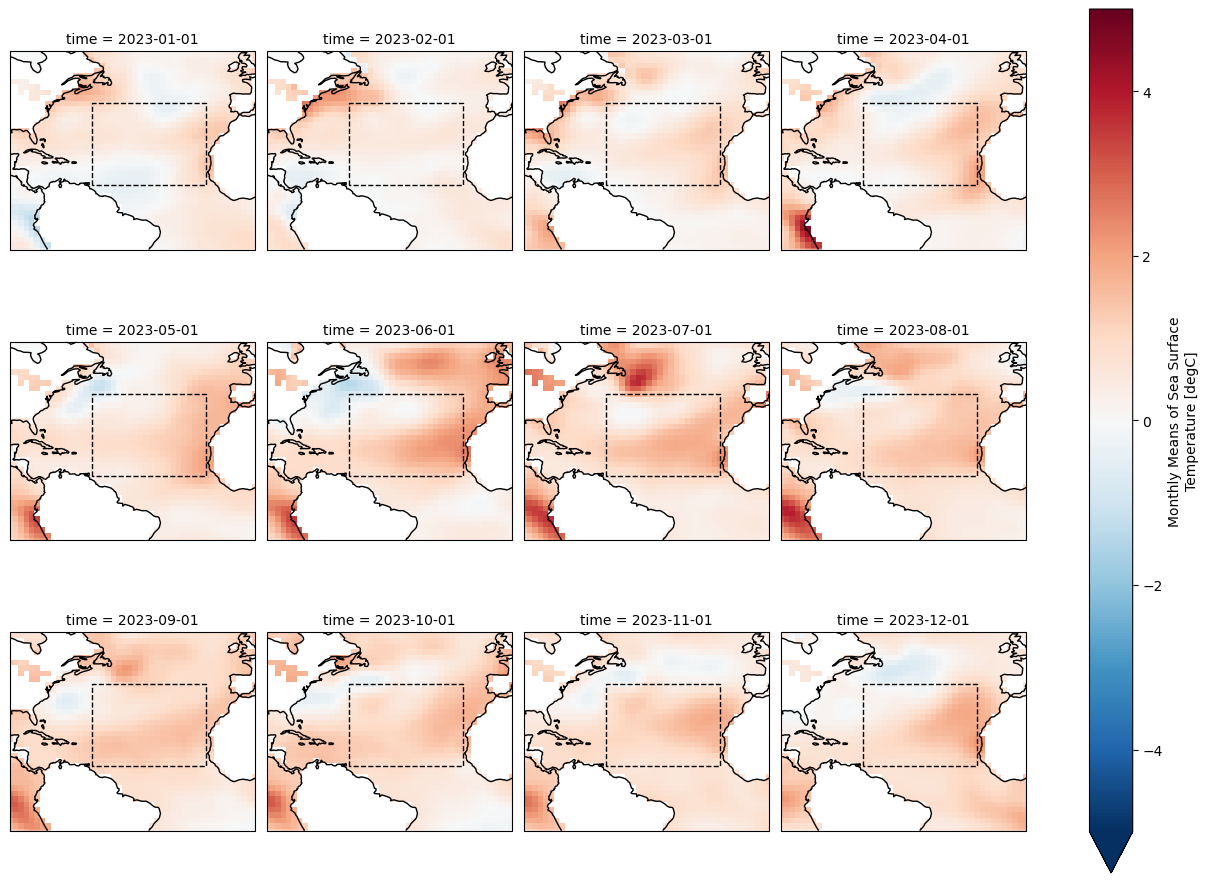

In [4]:
# map of 2023 anomaly in this region
sst_mclim = sst.sel(time = slice("1990", "2020")).groupby("time.month").mean()
sst_manom = (sst.sel(time = "2023").groupby("time.month") - sst_mclim).reset_coords(drop = True)

sst_manom.plot(col = "time", col_wrap = 4, vmin = -5, vmax = 5, cmap = "RdBu_r", add_colorbar = True,
               subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : [-90,0,-10,50]})

for ax in plt.gcf().axes[:12]:
    ax.coastlines()
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "k", lw = 1, ls = "--")
    ax.plot([-170,-170,-120,-120,-170], [-5,5,5,-5,-5], color = "k", lw = 1, ls = "--")

In [5]:
sst_mean_na = awmean(sst.sel(lon = slice(xn,xx), lat = slice(yn,yx)))
sst_rs_na = sst_mean_na.sel(time = [m > 4 for m in sst_mean_na.time.dt.month]).resample(time = "AS-JAN").mean()

sst_mean_tropical = awmean(sst.sel(lat = slice(-20,20)))
sst_rs_tropical = sst_mean_tropical.sel(time = [m > 4 for m in sst_mean_tropical.time.dt.month]).resample(time = "AS-JAN").mean()

sst_mean_nino34 = awmean(sst.sel(lat = slice(-5,5), lon = slice(-170,-120))) - sst_mean_tropical
sst_rs_nino34 = sst_mean_nino34.sel(time = [m > 4 for m in sst_mean_nino34.time.dt.month]).resample(time = "AS-JAN").mean()

Text(0.5, 1.0, 'Tropical')

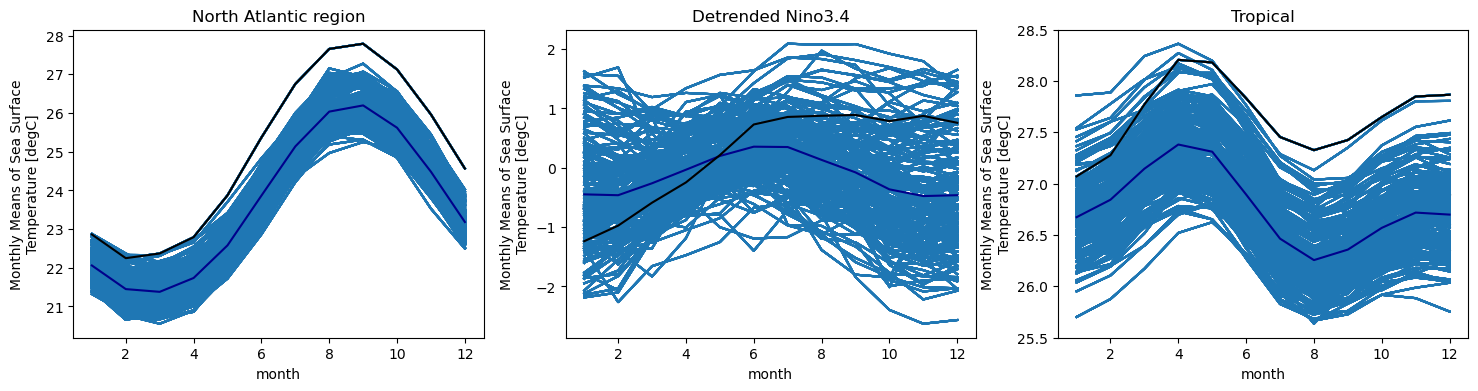

In [128]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,4), dpi = 100)

for y in sst_mean_na.time.dt.year.values:
    
    sst_mean_na.sel(time = str(y)).groupby("time.month").mean().plot(ax = axs[0], color = "tab:blue")
    sst_mean_nino34.sel(time = str(y)).groupby("time.month").mean().plot(ax = axs[1], color = "tab:blue")
    sst_mean_tropical.sel(time = str(y)).groupby("time.month").mean().plot(ax = axs[2], color = "tab:blue")

sst_mean_na.groupby("time.month").mean().plot(ax = axs[0], color = "darkblue")
sst_mean_na.sel(time = "2023").groupby("time.month").mean().plot(ax = axs[0], color = "k")
axs[0].set_title("North Atlantic region")

sst_mean_nino34.groupby("time.month").mean().plot(ax = axs[1], color = "darkblue")
sst_mean_nino34.sel(time = "2023").groupby("time.month").mean().plot(ax = axs[1], color = "k")
axs[1].set_title("Detrended Nino3.4")

sst_mean_tropical.groupby("time.month").mean().plot(ax = axs[2], color = "darkblue")
sst_mean_tropical.sel(time = "2023").groupby("time.month").mean().plot(ax = axs[2], color = "k")
axs[2].set_title("Tropical")


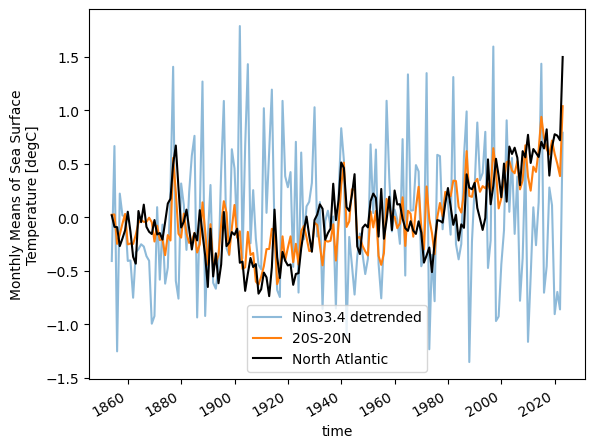

In [130]:
(sst_rs_nino34 - sst_rs_nino34.mean()).plot(label = "Nino3.4 detrended", alpha = 0.5)
(sst_rs_tropical - sst_rs_tropical.mean()).plot(label = "Tropical (20S-20N)")
(sst_rs_na - sst_rs_na.mean()).plot(color = "k", label = "North Atlantic")
plt.legend()

In [7]:
sst_rs_na.assign_coords(time = sst_rs_na.time.dt.year).rename(time = "year").to_pandas().to_csv("ts/panama_atlanticsst-rs.csv")

# Prep for monthly model

In [11]:
xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.sel(time = slice(None, "2023")).to_pandas().to_csv("data/monthly_nino34.csv")
xr.open_dataset("data/pr_monthly_acp-1925.nc").pr.to_pandas().to_csv("data/monthly_pr-acp1925.csv")